# Финальный проект

Задача заключается в прогнозировании оттока клиентов.
Данные об оттоке клиентов записаны в файл Verizon.csv.
Новые данные дл получения прогнозных вероятностей оттока в файле Verizon_new.csv

По каждому клиенту (наблюдению) фиксируются следующие переменные:
- Длительность междугородних звонков - `longdist`
- Длительность международных звонков - `internat`
- Длительность местных звонков - `local`
- Скидка на интернет - `int_disc`
- Тип счета - `billtype`
- Способ оплаты - `pay`
- Возраст клиента - `age`
- Пол клиента - `gender`
- Семейное положение клиента - `marital`
- Количество детей у клиента - `children`
- Доход клиента - `income`
- Отток клиента - `churn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Импортируем класс PowerTransformer, позволяющий выполнить
# преобразование Бокса-Кокса и стандартизацию
from sklearn.preprocessing import (PowerTransformer,
                                   OneHotEncoder)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import display
from tqdm.notebook import tqdm
from matplotlib.cm import tab10, tab20

from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [2]:
data = pd.read_csv('Verizon.csv', sep=';')

In [3]:
data.head()

,longdist,internat,local,int_disc,billtype,pay,age,gender,marital,children,income,churn
0,8.62,NaN,8.49,Нет,Бюджетный,CH,43.0,Мужской,_Женат,0.0,33935.8,0
1,21.27,0.0,"218,12",Нет,Бюджетный,CH,60.0,NaN,_Одинокий,2.0,"95930,6",1
2,"6,13",0.0,NaN,Да,NaN,NaN,25.0,Женский,NaN,2.0,"295,34",1
3,16.46,0.0,"57,66",Да,Бесплатный,NaN,93.0,Женский,Одинокий,0.0,NaN,1
4,NaN,0.0,"16,01",Да,Бесплатный,CC,68.0,Женский&*,NaN,0.0,"99832,9",1


Видим, что в количественных переменных `longdist`, `internat`, `local` и `income` в качестве десятичного разделителя используется как точка, так и запятая, есть пропуски, в строковых значениях категориальных переменных `gender` и `marital` встречаются символы

Посмотрим наличие дублей

In [4]:
data[data.duplicated(keep=False)]

,longdist,internat,local,int_disc,billtype,pay,age,gender,marital,children,income,churn
0,8.62,NaN,8.49,Нет,Бюджетный,CH,43.0,Мужской,_Женат,0.0,33935.8,0
13,8.62,NaN,8.49,Нет,Бюджетный,CH,43.0,Мужской,_Женат,0.0,33935.8,0
14,8.62,NaN,8.49,Нет,Бюджетный,CH,43.0,Мужской,_Женат,0.0,33935.8,0


Удалим дубликаты, оставив первое встретившиеся наблюдение

In [5]:
data.drop_duplicates(subset=None, keep='first', inplace=True)

Ищем бесполезные переменные, т.е. с одним уникальным значением и категориальные переменные, у которых категой столько же, сколько уникальных значений

In [6]:
# Создаем список переменных
cols_lst = data.columns.tolist()
# Записываем количество уникальных значений по каждой переменной
uniq = [data[col].nunique() for col in cols_lst]
# Записываем тип каждой переменной
types = data.dtypes
pd.DataFrame({'type': types, 'n_uniq': uniq})

,type,n_uniq
longdist,object,1081
internat,object,218
local,object,1372
int_disc,object,2
billtype,object,2
pay,object,4
age,float64,80
gender,object,4
marital,object,5
children,float64,3


Бесполезных переменных нет. Но есть проблемы с количественными переменными `longdist`, `internat`, `local` и `income`, из-за десятичного разделителя - запятой, они записаны как категориальные.
Заменим запятые на точки и преобразуем тип на float:

In [7]:
for col in ['longdist', 'internat', 'local', 'income']:
    data[col] = data[col].str.replace(',', '.').astype('float')

Проверим типы переменных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475 entries, 0 to 1476
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   longdist  1467 non-null   float64
 1   internat  1469 non-null   float64
 2   local     1466 non-null   float64
 3   int_disc  1471 non-null   object 
 4   billtype  1450 non-null   object 
 5   pay       1470 non-null   object 
 6   age       1473 non-null   float64
 7   gender    1469 non-null   object 
 8   marital   1471 non-null   object 
 9   children  1474 non-null   float64
 10  income    1471 non-null   float64
 11  churn     1475 non-null   int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 149.8+ KB


Посмотрим количество пропусков

In [9]:
data.isnull().sum()

longdist     8
internat     6
local        9
int_disc     4
billtype    25
pay          5
age          2
gender       6
marital      4
children     1
income       4
churn        0
dtype: int64

Все переменные, кроме отклика `churn`, имеют пропуски

Выведем уникальные значения по каждой категориальной переменной

In [10]:
# Создаем список категориальных переменных
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
# Получаем и выводим уникальные значения этих переменных
for col in cat_cols:
    print(col, data[col].unique())

int_disc ['Нет' 'Да' nan]
billtype ['Бюджетный' nan 'Бесплатный']
pay ['CH' nan 'CC' 'CD' 'Auto']
gender ['Мужской' nan 'Женский' 'Женский&*' 'Мужской&*']
marital ['_Женат' '_Одинокий' nan 'Одинокий' 'Женат' 'Же&нат']


Удалим лишние символы `* & _`

In [11]:
for col in ['gender', 'marital']:
    data[col] = data[col].str.replace('[*&_]','')
# Проверяем
for col in ['gender', 'marital']:
    print(col, data[col].unique())

gender ['Мужской' nan 'Женский']
marital ['Женат' 'Одинокий' nan]


Чтобы выявить редкие категории, посмотрим частоты категорий по категориальным переменным

In [12]:
for col in cat_cols:
    print(data[col].value_counts(dropna=False))
    print('')

Нет    1015
Да      456
NaN       4
Name: int_disc, dtype: int64

Бюджетный     731
Бесплатный    719
NaN            25
Name: billtype, dtype: int64

CC      846
CH      324
Auto    297
NaN       5
CD        3
Name: pay, dtype: int64

Женский    743
Мужской    726
NaN          6
Name: gender, dtype: int64

Женат       872
Одинокий    599
NaN           4
Name: marital, dtype: int64



Обнаружилась редкая категория `CD` в переменной `pay`. Заменим редкую категорию модой

In [13]:
data.loc[data['pay'] == 'CD', 'pay'] = 'CC'

### Создание новых признаков

Создадим переменную, связывающую переменные `gender` и `marital`, соединив их строковые значения

In [14]:
data['gender_marital'] = np.where(
    (data['gender'].isnull()) | (data['marital'].isnull()),
    np.NaN,
    data.apply(lambda x: f"{x['gender']} + {x['marital']}", axis=1)
)

Если хотя бы в одной из переменных есть пропуск, то в связь мы записываем пропуск. Такая стратегия обычно используется, когда пропуски редки, как в данном случае. Здесь значение NaN является временным, после разбиения на обучающую и тестовую выборку нужно будет заменить его модой

Создадим переменные-отношения:

Поделим возрас на длительность междугородних звонков в минутах:

In [15]:
cond = (data['age']==0) | (data['longdist']==0)
data['ratio']= np.where(cond, 0, data['age']/data['longdist'])

Поделим длительность междугородних звонков в минутах на длительность муждународных звонков в минутах

In [16]:
cond = (data['longdist']==0) | (data['internat']==0)
data['ratio2']= np.where(cond, 0, data['longdist']/data['internat'])

Поделим доход на возраст

In [17]:
cond = (data['income']==0) | (data['age']==0)
data['ratio3']= np.where(cond, 0, data['income']/data['age'])

Поделим возраст на количество детей

In [18]:
cond = (data['age']==0) | (data['children']==0)
data['ratio4']= np.where(cond, 0, data['age']/data['children'])

### Подготовка обучающей и тестовой выборок

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('churn',axis=1),
    data['churn'],
    test_size=0.3,
    stratify=data['churn'],
    random_state=SEED
)

Создадим список категориальных признаков и список количественных признаков

In [20]:
cat_columns = X_train.select_dtypes(include='object').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

Создадим трансформер, и конвейер с моделью

In [21]:
# Трансформер для категориальных переменных
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [22]:
# Трансформер для количественных переменных
num_pipe = Pipeline([
    ('imp', SimpleImputer())
    #('boxcox', PowerTransformer(method='box-cox', standardize=True))
])

Объединяем трансформеры и предаем в ColumnTransformer

In [23]:
transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]
ct = ColumnTransformer(transformers=transformers)

Создаём итоговый конвейер

In [24]:
ml_pipe = Pipeline([
    ('tr', ct),
    ('logreg', LogisticRegression(solver='liblinear'))
])

Обучаем конвейер и оцениваем качество на обучающих и тестовых данных

In [25]:
ml_pipe.fit(X_train, y_train)
print('AUC-ROC на обучающей выборке: {:.3f}'.format(
    roc_auc_score(y_train,ml_pipe.predict_proba(X_train)[:, 1])))
print('AUC-ROC на тестовой выборке: {:.3f}'.format(
    roc_auc_score(y_test, ml_pipe.predict_proba(X_test)[:, 1])))

AUC-ROC на обучающей выборке: 0.851
AUC-ROC на тестовой выборке: 0.845


Создадим сетку значений гиперпараметров

In [26]:
param_grid = {
    'tr__num__imp__strategy': ['mean', 'median', 'constant'],
    'tr__cat__imp__strategy': ['most_frequent', 'constant'],
    'logreg__C': np.logspace(-2, 1, 10)
}

Создаем поиск по сетке и выведем наилучшие гиперпараметры, метрики на обучающей и тестовой выборке

In [27]:
gs = GridSearchCV(ml_pipe, param_grid, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print('Наилучшие значения гиперпараметров: \n{}'.format(gs.best_params_))
print('Наилучшее значение AUC-ROC: {:.3f}'.format(gs.best_score_))
print('Наилучшее значение AUC-ROC на тестовой выборке: {:.3f}'.format(
    roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])))

Наилучшие значения гиперпараметров: 
{'logreg__C': 4.6415888336127775, 'tr__cat__imp__strategy': 'most_frequent', 'tr__num__imp__strategy': 'constant'}
Наилучшее значение AUC-ROC: 0.841
Наилучшее значение AUC-ROC на тестовой выборке: 0.843


Посмотрим на ROC кривую

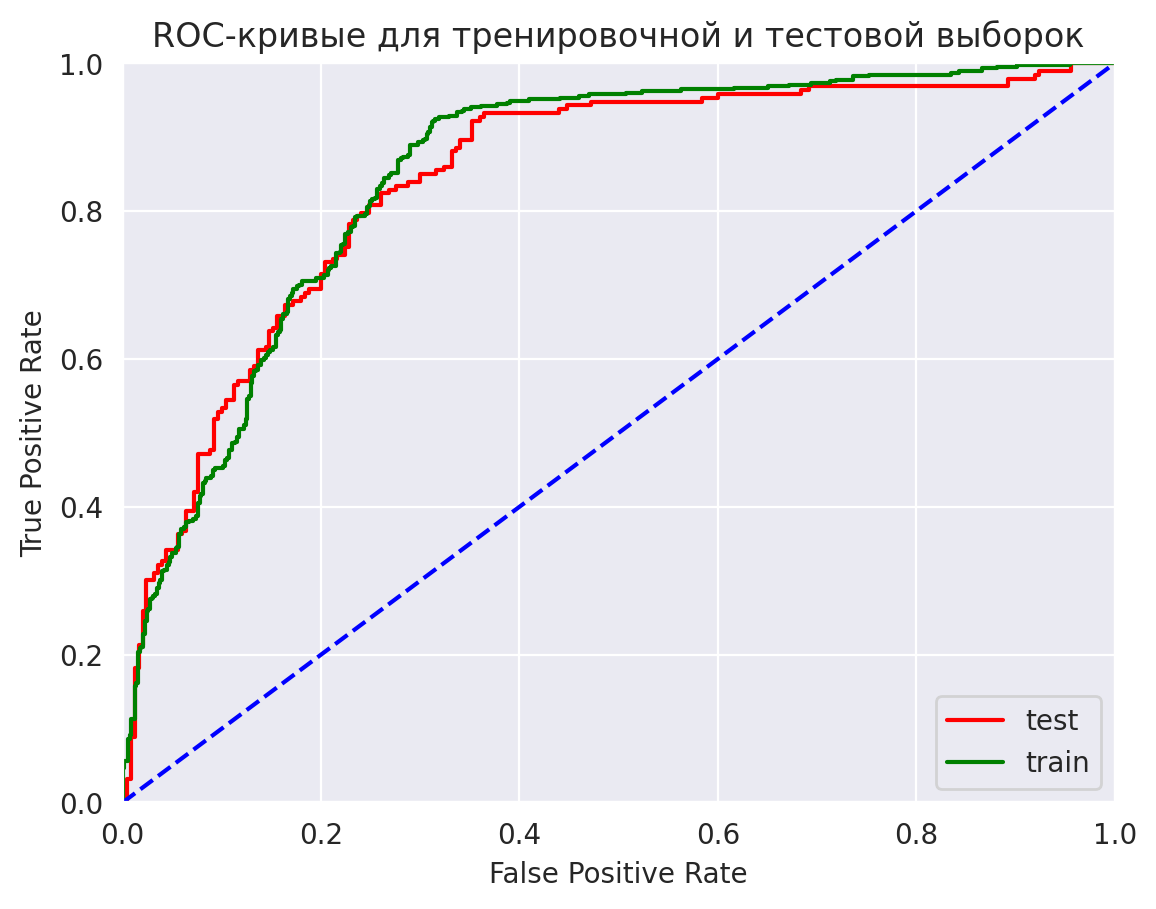

In [28]:
fpr_test, tpr_test, tresholds_test = roc_curve(y_test, gs.predict_proba(X_test)[:, 1])
fpr_train, tpr_train, tresholds_train = roc_curve(y_train, gs.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test, color='red', label='test')
plt.plot(fpr_train, tpr_train, color='green', label='train')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тренировочной и тестовой выборок')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

Запишем результаты и превратим в сводную таблицу

In [29]:
results = pd.DataFrame(gs.cv_results_)
table = results.pivot_table(
    values=['mean_test_score'],
    index=['param_logreg__C',
           'param_tr__num__imp__strategy',
           'param_tr__cat__imp__strategy'])
table.sort_values('mean_test_score',
                  ascending=False,
                  inplace=True)
table

,,,mean_test_score
param_logreg__C,param_tr__num__imp__strategy,param_tr__cat__imp__strategy,
4.641589,constant,most_frequent,0.841289
0.215443,constant,constant,0.841041
0.464159,constant,constant,0.840581
1.000000,constant,most_frequent,0.840565
0.046416,constant,most_frequent,0.840156
1.000000,mean,most_frequent,0.840066
10.000000,mean,constant,0.839701
0.046416,mean,most_frequent,0.839550
4.641589,mean,most_frequent,0.839455


Мы нашли оптимальные значения гиперпараметров, теперь нам надо обучить конвейер с этими оптиммальными значениями на всей исторической выборке

Загружаем заново все данные

In [30]:
fulldata = pd.read_csv('Verizon.csv', sep=';')

Напишем функцию, выполняющую предварительную обработку всех исторических данных

In [31]:
def preprocessing(df):
    # удаляем дубликаты
    df.drop_duplicates(subset=None, keep='first', inplace=True)
    # заменяем запятые и преобразуем тип
    for i in ['longdist', 'internat', 'local', 'income']:
        df[i] = df[i].str.replace(',', '.').astype('float')
    # удаляем лишние символы
    for i in ['gender', 'marital']:
        df[i] = df[i].str.replace('[\d+\W_]','')
    # все новые категории переменной pay заменяем модой
    lst = ['CC', 'Auto', 'CH', np.NaN]
    replace_new_values = lambda x: 'CC' if x not in lst else x
    df['pay'] =df['pay'].map(replace_new_values)
    # создаем переменную - результат совмещения
    df['gender_marital'] = np.where(
        (df['gender'].isnull()) | (df['marital'].isnull()),
        np.NaN,
        df.apply(lambda x: f"{x['gender']} + {x['marital']}", axis=1))
    # создадим дополнительные переменные-отношения
    cond = (df['age']==0) | (df['longdist']==0)
    df['ratio']= np.where(cond, 0, df['age']/df['longdist'])
    cond = (df['longdist']==0) | (df['internat']==0)
    df['ratio2']= np.where(cond, 0, df['longdist']/df['internat'])
    cond = (df['income']==0) | (df['age']==0)
    df['ratio3']= np.where(cond, 0, df['income']/df['age'])
    cond = (df['age']==0) | (df['children']==0)
    df['ratio4']= np.where(cond, 0, df['age']/df['children'])
    return df

Применим функцию ко всем историческим данным

In [32]:
fulldata = preprocessing(fulldata)
fulldata.head()

,longdist,internat,local,int_disc,billtype,pay,age,gender,marital,children,income,churn,gender_marital,ratio,ratio2,ratio3,ratio4
0,8.62,NaN,8.49,Нет,Бюджетный,CH,43.0,Мужской,Женат,0.0,33935.80,0,Мужской + Женат,4.988399,NaN,789.204651,0.0
1,21.27,0.0,218.12,Нет,Бюджетный,CH,60.0,NaN,Одинокий,2.0,95930.60,1,NaN,2.820874,0.0,1598.843333,30.0
2,6.13,0.0,NaN,Да,NaN,NaN,25.0,Женский,NaN,2.0,295.34,1,NaN,4.078303,0.0,11.813600,12.5
3,16.46,0.0,57.66,Да,Бесплатный,NaN,93.0,Женский,Одинокий,0.0,NaN,1,Женский + Одинокий,5.650061,0.0,NaN,0.0
4,NaN,0.0,16.01,Да,Бесплатный,CC,68.0,Женский,NaN,0.0,99832.90,1,NaN,NaN,0.0,1468.130882,0.0


Создадим массив меток и массив признаков

In [33]:
y_fulldata = fulldata.pop('churn')

Извлекаем оптимальные гиперпараметры и передаем его в конвейер

In [34]:
best_params = gs.best_params_
ml_pipe.set_params(**best_params)

Pipeline(steps=[('tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['longdist', 'internat',
                                                   'local', 'age', 'children',
                                                   'income', 'ratio', 'ratio2',
                                                   'ratio3', 'ratio4']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
             

Обучаем итоговый конвейер с оптимальными значениями на всех исторических данных

In [35]:
ml_pipe.fit(fulldata, y_fulldata)

Pipeline(steps=[('tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['longdist', 'internat',
                                                   'local', 'age', 'children',
                                                   'income', 'ratio', 'ratio2',
                                                   'ratio3', 'ratio4']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
             

Загрузим новые данные и посмотрим на них

In [36]:
newdata = pd.read_csv('Verizon_new.csv', sep=';')
newdata.head()

,longdist,internat,local,int_disc,billtype,pay,age,gender,marital,children,income
0,"19,46","7,11","64,51",Нет,Бюджетный,CH,28.0,Женский7,Одинокий,1.0,43787
1,"18,42","6,46","28,07",Да,Бесплатный,CH,35.0,Женский&*,Женат,2.0,"47396,2"
2,"10,97",0,60,Да,Бесплатный,CH,45.0,Мужской$,Женат,0.0,"30057,4"
3,"22,18",0,"149,73",Нет,Бесплатный,HH,41.0,Мужской$,Одинокий,1.0,"21126,7"
4,0,0,"4,15",Да,Бесплатный,CH,40.0,Женский&*,_Одинокий,2.0,"81000,9"


Применяем функцию предварительной подготовки

In [37]:
newdata = preprocessing(newdata)
newdata.head()

,longdist,internat,local,int_disc,billtype,pay,age,gender,marital,children,income,gender_marital,ratio,ratio2,ratio3,ratio4
0,19.46,7.11,64.51,Нет,Бюджетный,CH,28.0,Женский,Одинокий,1.0,43787.0,Женский + Одинокий,1.438849,2.736990,1563.821429,28.0
1,18.42,6.46,28.07,Да,Бесплатный,CH,35.0,Женский,Женат,2.0,47396.2,Женский + Женат,1.900109,2.851393,1354.177143,17.5
2,10.97,0.00,60.00,Да,Бесплатный,CH,45.0,Мужской,Женат,0.0,30057.4,Мужской + Женат,4.102097,0.000000,667.942222,0.0
3,22.18,0.00,149.73,Нет,Бесплатный,CC,41.0,Мужской,Одинокий,1.0,21126.7,Мужской + Одинокий,1.848512,0.000000,515.285366,41.0
4,0.00,0.00,4.15,Да,Бесплатный,CH,40.0,Женский,Одинокий,2.0,81000.9,Женский + Одинокий,0.000000,0.000000,2025.022500,20.0


Напишем функцию, проверяющую порядок признаков в наборах. В ряде ситуаций несовпадение порядка столбцов в историческом наборе и наборе новых данных может дать некорректные результаты.

In [38]:
def check_vars_order(hist_data, new_data):
    if hist_data == new_data:
        print('Одни и те же списки переменных, '+
              'один и тот же порядок.')
    elif sorted(hist_data) == sorted(new_data):
        print('Одни и те же списки переменных, '+
              'разный порядок.')
    else:
        print('Совершенно разные списки переменных.')

Выполним проверку на историческом наборе и новых данных

In [39]:
# Создадим списки переменных для наборов данных
fulldata_cols = fulldata.columns.tolist()
newdata_cols = newdata.columns.tolist()
check_vars_order(fulldata_cols, newdata_cols)

Одни и те же списки переменных, один и тот же порядок.


Используя конвейер с оптимальными гиперпараметрами, обученный на всей исторической выборке, вычислим вероятности классов для новых данных

In [40]:
proba = ml_pipe.predict_proba(newdata)
proba[:5]

array([[0.10273417, 0.89726583],
       [0.08979415, 0.91020585],
       [0.83668686, 0.16331314],
       [0.90567065, 0.09432935],
       [0.30900604, 0.69099396]])

# Вывод

1. В данном проекте основной целью ставилась задача по созданию конвейера для применения на реальной задаче, когда нужно спрогнозировать вероятности оттока клиентов на новых данных.
2. В качестве модели использовалась только логистическая регрессия. т.к. основной упор сделан на формировании конвейера, то для упрощения оставлена только одна модель. Добавить другие модели классификации, при появлении необходимости,не составит труда.
3. Выполнена:
   * Предварительная обработка данных
   * Обработаны дубликаты
   * Добавлены новые признаки отношения
4. Подготовлены трансформеры и конвейеры для преобразования данных.
5. На размеченном датасете выполнено разделение на тренировочную и тестовую выборки
6. С помощью перебора по сетке с использованием кросс-валидации получены оптимальные гиперпараметры
7. Затем с полученными оптимальными гиперпараметрами модель обучена на полном датасете.
8. Для новых данных рассчитаны вероятности оттока клиентов
9. На основе полученных вероятностей, используя граничное значение вероятности, можно получить список клиентов с риском ухода для предложения им скидки или промокода